<a href="https://colab.research.google.com/github/snehotosh/Deep-Learning/blob/master/Cat_Dog_Detection_Keras_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras

Using TensorFlow backend.


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from keras.models import Model,Sequential
from keras.preprocessing import utils
from keras.optimizers import Adam,SGD
from keras import backend as K
from keras.metrics import categorical_crossentropy,binary_crossentropy
from keras.layers import Conv2D,Dropout,Input,MaxPooling2D,Dense,Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import ResNet50,preprocess_input

import matplotlib.pyplot as plt

In [4]:
! ls

sample_data


In [5]:
## Importing the dataset
! wget http://files.fast.ai/data/dogscats.zip

--2019-04-28 15:12:04--  http://files.fast.ai/data/dogscats.zip
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 857214334 (818M) [application/zip]
Saving to: ‘dogscats.zip’

dogscats.zip        100%[===================>] 817.50M  29.9MB/s    in 28s     

2019-04-28 15:12:32 (29.4 MB/s) - ‘dogscats.zip’ saved [857214334/857214334]



In [10]:
! unzip dogscats.zip

Archive:  dogscats.zip
   creating: dogscats/
   creating: dogscats/sample/
   creating: dogscats/sample/train/
   creating: dogscats/sample/train/cats/
  inflating: dogscats/sample/train/cats/cat.2921.jpg  
  inflating: dogscats/sample/train/cats/cat.394.jpg  
  inflating: dogscats/sample/train/cats/cat.4865.jpg  
  inflating: dogscats/sample/train/cats/cat.3570.jpg  
  inflating: dogscats/sample/train/cats/cat.2266.jpg  
  inflating: dogscats/sample/train/cats/cat.9021.jpg  
  inflating: dogscats/sample/train/cats/cat.11737.jpg  
  inflating: dogscats/sample/train/cats/cat.4600.jpg  
   creating: dogscats/sample/train/dogs/
  inflating: dogscats/sample/train/dogs/dog.1402.jpg  
  inflating: dogscats/sample/train/dogs/dog.1614.jpg  
  inflating: dogscats/sample/train/dogs/dog.8643.jpg  
  inflating: dogscats/sample/train/dogs/dog.6391.jpg  
  inflating: dogscats/sample/train/dogs/dog.2423.jpg  
  inflating: dogscats/sample/train/dogs/dog.9077.jpg  
  inflating: dogscats/sample/train/d

In [0]:
PATH = '/content/dogscats/'

In [0]:
## Reading one Image
from skimage import io

(280, 300, 3)


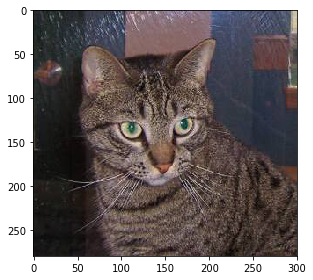

In [13]:
img_arr = io.imread(fname=f'{PATH}train/cats/cat.1.jpg')
print(img_arr.shape) ## Each Image is of different shape
io.imshow(img_arr)

In [0]:
## Setting the parameters
IMG_SIZE = (224, 224)
EPOCHS = 20
NUM_CLASSES = 2
BATCH_SIZE = 4
WEIGHTS_FINAL = 'model-resnet50-final.h5'
FREEZE_LAYERS = 2

In [15]:
## Defining Model
model = ResNet50(include_top=False, weights='imagenet', input_tensor=Input(shape=(IMG_SIZE[0],IMG_SIZE[1],3)))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________

In [0]:
for layer in model.layers:
    layer.trainable = False

In [17]:
x = model.output
x = Flatten()(x)
x = Dropout(0.5)(x)
output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)
net_final = Model(inputs=model.input, outputs=output_layer)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [18]:
net_final.compile(optimizer=Adam(lr=1e-5),loss='binary_crossentropy', metrics=['accuracy'])
print(net_final.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [19]:
train_data_dir = f'{PATH}train'
validation_data_dir = f'{PATH}valid'

#train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
#                                   rotation_range=40,
#                                   width_shift_range=0.2,
#                                   height_shift_range=0.2,
#                                   shear_range=0.2,
#                                   zoom_range=0.2,
#                                   channel_shift_range=10,
#                                   horizontal_flip=True,
#                                   fill_mode='nearest')

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_batches = train_datagen.flow_from_directory(train_data_dir,
                                                  target_size=IMG_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

valid_batches = valid_datagen.flow_from_directory(validation_data_dir,
                                                  target_size=IMG_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE)


Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [0]:
# train the model
net_final.fit_generator(train_batches,
                        steps_per_epoch = train_batches.samples // BATCH_SIZE,
                        validation_data = valid_batches,
                        validation_steps = valid_batches.samples // BATCH_SIZE,
                        epochs = EPOCHS)


Instructions for updating:
Use tf.cast instead.
Epoch 1/20
 859/5750 [===>..........................] - ETA: 5:47 - loss: 0.5958 - acc: 0.8102

https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/

https://github.com/jkjung-avt/keras-cats-dogs-tutorial

https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html